# Initializing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import kagglehub
import os
from pathlib import Path

c:\Users\Alex\Desktop\TS pmo\stat-learning-final-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Downloading the dataset

In [2]:
path = kagglehub.dataset_download("asaniczka/forex-exchange-rate-since-2004-updated-daily")

print("Path to dataset files:", path)

# Move extracted files to a data/raw directory
raw_data_dir = Path("../data/raw")
raw_data_dir.mkdir(parents=True, exist_ok=True)
for file_name in os.listdir(path):
    source = Path(path) / file_name
    destination = raw_data_dir / file_name
    source.rename(destination)

100%|██████████| 2.57M/2.57M [00:00<00:00, 3.31MB/s]

Extracting files...


Path to dataset files: C:\Users\Alex\.cache\kagglehub\datasets\asaniczka\forex-exchange-rate-since-2004-updated-daily\versions\768


In [3]:
df = pd.read_csv(raw_data_dir / "daily_forex_rates.csv")
df.head()

,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,374.983176,2025-12-06
1,GHS,EUR,Ghanaian Cedi,13.246811,2025-12-06
2,HRK,EUR,Croatian Kuna,7.535429,2025-12-06
3,HNL,EUR,Honduran Lempira,30.671248,2025-12-06
4,HKD,EUR,Hong Kong Dollar,9.102558,2025-12-06


# Filtering values for KZT/EUR

In [4]:
df_kzt = df[df['currency'] == 'KZT'].sort_values(by='date').reset_index(drop=True)
df_kzt = df_kzt[['date', 'exchange_rate']]
df_kzt.head(15)

,date,exchange_rate
0,2014-11-24,225.15
1,2014-11-25,225.58
2,2014-11-26,226.18
3,2014-11-27,225.52
4,2014-11-28,225.93
5,2014-12-01,226.29
6,2014-12-02,224.87
7,2014-12-03,223.76
8,2014-12-04,225.05
9,2014-12-05,223.21


In [5]:
df_kzt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3097 entries, 0 to 3096
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3097 non-null   object 
 1   exchange_rate  3097 non-null   float64
dtypes: float64(1), object(1)
memory usage: 48.5+ KB


# Filling in the missing dates (holidays/weekends)

In [6]:
df_kzt['date'] = pd.to_datetime(df_kzt['date'])

df_kzt = df_kzt.set_index('date')

full_range = pd.date_range(start=df_kzt.index.min(), end=df_kzt.index.max(), freq='D')
df_kzt = df_kzt.reindex(full_range).ffill()

df_kzt = df_kzt.rename_axis('date').reset_index()

df_kzt.head(15)

,date,exchange_rate
0,2014-11-24,225.15
1,2014-11-25,225.58
2,2014-11-26,226.18
3,2014-11-27,225.52
4,2014-11-28,225.93
5,2014-11-29,225.93
6,2014-11-30,225.93
7,2014-12-01,226.29
8,2014-12-02,224.87
9,2014-12-03,223.76


# Visualizing the data

In [7]:
line = px.line(df_kzt, x='date', y='exchange_rate', title='KZT Exchange Rate Over Time')
line.show()

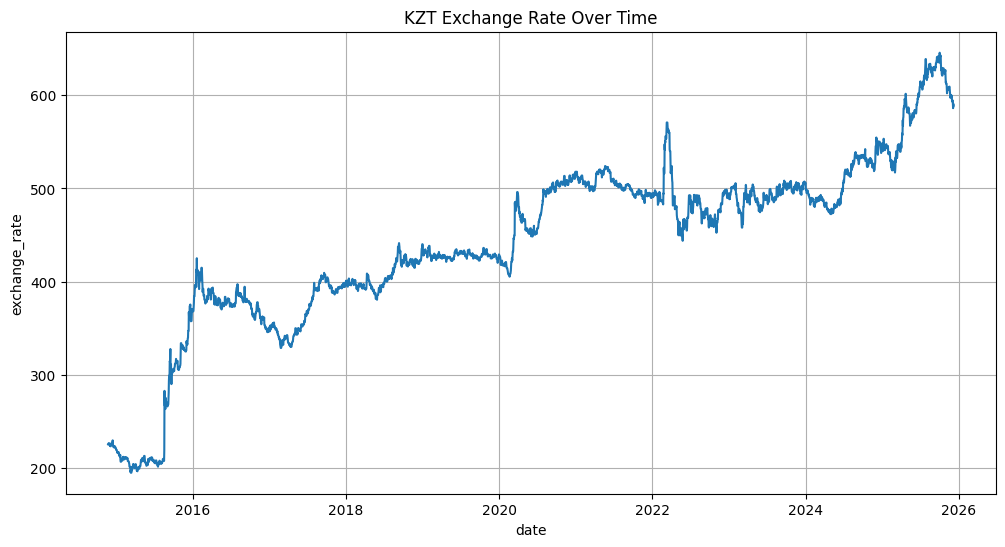

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_kzt, x='date', y='exchange_rate')
plt.title('KZT Exchange Rate Over Time')
plt.grid()
plt.show()

# Saving the dataset for classical TS analysis

In [8]:
processed_data_dir = Path("../data/processed")
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [9]:
df_kzt.to_csv(processed_data_dir / "kzt_exchange_rates_processed_classic.csv", index=False)

# Feature Engineering for ML-based approaches

In [10]:
df_ml = df_kzt.copy()

df_ml['exchange_rate_next_day'] = df_ml['exchange_rate'].shift(-1)
df_ml['exchange_rate_next_week'] = df_ml['exchange_rate'].shift(-7)

df_ml['lag_1'] = df_ml['exchange_rate'].shift(1)
df_ml['lag_2'] = df_ml['exchange_rate'].shift(2)
df_ml['lag_7'] = df_ml['exchange_rate'].shift(7)
df_ml['lag_30'] = df_ml['exchange_rate'].shift(30)

df_ml['lag_1_diff'] = df_ml['lag_1'].diff()
df_ml['lag_2_diff'] = df_ml['lag_2'].diff()
df_ml['lag_7_diff'] = df_ml['lag_7'].diff()
df_ml['lag_30_diff'] = df_ml['lag_30'].diff()
df_ml['rolling_3'] = df_ml['exchange_rate'].shift(1).rolling(3).mean()
df_ml['rolling_7'] = df_ml['exchange_rate'].shift(1).rolling(7).mean()
df_ml['rolling_30'] = df_ml['exchange_rate'].shift(1).rolling(30).mean()

df_ml['weekday'] = df_ml['date'].dt.weekday
df_ml['weekday_sin'] = np.sin(2 * np.pi * df_ml['weekday'] / 7)
df_ml['weekday_cos'] = np.cos(2 * np.pi * df_ml['weekday'] / 7)

df_ml['month'] = df_ml['date'].dt.month
df_ml['month_sin'] = np.sin(2 * np.pi * df_ml['month'] / 12)
df_ml['month_cos'] = np.cos(2 * np.pi * df_ml['month'] / 12)

# df_ml['trend'] = np.arange(len(df_ml))

df_ml.drop(columns=['weekday', 'month'], inplace=True)

df_ml

,date,exchange_rate,exchange_rate_next_day,exchange_rate_next_week,lag_1,lag_2,lag_7,lag_30,lag_1_diff,lag_2_diff,lag_7_diff,lag_30_diff,rolling_3,rolling_7,rolling_30,weekday_sin,weekday_cos,month_sin,month_cos
0,2014-11-24,225.150000,225.580000,226.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,-5.000000e-01,0.866025
1,2014-11-25,225.580000,226.180000,224.87,225.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.781831,0.623490,-5.000000e-01,0.866025
2,2014-11-26,226.180000,225.520000,223.76,225.580000,225.150000,NaN,NaN,0.430000,NaN,NaN,NaN,NaN,NaN,NaN,0.974928,-0.222521,-5.000000e-01,0.866025
3,2014-11-27,225.520000,225.930000,225.05,226.180000,225.580000,NaN,NaN,0.600000,0.430000,NaN,NaN,225.636667,NaN,NaN,0.433884,-0.900969,-5.000000e-01,0.866025
4,2014-11-28,225.930000,225.930000,223.21,225.520000,226.180000,NaN,NaN,-0.660000,0.600000,NaN,NaN,225.760000,NaN,NaN,-0.433884,-0.900969,-5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,2025-12-02,594.603375,589.297593,NaN,593.797681,593.456058,600.415769,612.471437,0.341623,0.000000,0.960599,0.000000,593.569932,596.631288,603.462833,0.781831,0.623490,-2.449294e-16,1.000000
4027,2025-12-03,589.297593,586.244422,NaN,594.603375,593.797681,598.158133,612.397339,0.805694,0.341623,-2.257636,-0.074098,593.952371,595.800946,602.867231,0.974928,-0.222521,-2.449294e-16,1.000000
4028,2025-12-04,586.244422,590.993703,NaN,589.297593,594.603375,599.360948,605.520886,-5.305782,0.805694,1.202815,-6.876453,592.566216,594.535155,602.097239,0.433884,-0.900969,-2.449294e-16,1.000000
4029,2025-12-05,590.993703,588.927154,NaN,586.244422,589.297593,597.774370,602.241896,-3.053171,-5.305782,-1.586578,-3.278990,590.048463,592.661365,601.454690,-0.433884,-0.900969,-2.449294e-16,1.000000


# Saving the dataset for ML models

In [11]:
df_ml.to_csv(processed_data_dir / "kzt_exchange_rates_processed_ml.csv", index=False)